# Exploratory Data Analysis - EDA



## Introducción
El presente análisis exploratorio se centra en el estudio de un conjunto de datos diseñado para la detección de comportamientos anómalos en un entorno de seguridad, con el objetivo de evaluar si la información disponible permite diferenciar de forma efectiva entre actividad legítima y potencialmente maliciosa. Dado que el enfoque adoptado se basa en técnicas de aprendizaje no supervisado, resulta fundamental caracterizar en profundidad el comportamiento normal del sistema y analizar cómo se manifiestan las desviaciones asociadas a escenarios de ataque. En este contexto, el EDA se orienta a identificar patrones temporales, distribuciones y relaciones entre variables que puedan ser indicativas de un ataque de Consul poisoning, así como a detectar posibles limitaciones del dataset que puedan afectar al posterior proceso de modelado.

## Descripción del problema
La arquitectura analizada está basada en microservicios desplegados en la nube (AWS) y utiliza Consul como mecanismo de service registry y service discovery. Cada microservicio, al iniciarse o reiniciarse, envía una petición de registro a Consul para anunciar su disponibilidad. Posteriormente, los microservicios consultan a Consul para resolver la ubicación de otros servicios dentro del sistema.

El ataque objeto de estudio es el denominado Consul Poisoning, un ataque dirigido al plano de control de la arquitectura. En este escenario, un atacante que ya ha conseguido acceso a la red interna es capaz de enviar peticiones maliciosas de registro a Consul, suplantando la identidad de servicios legítimos como auth u order. Como consecuencia, Consul puede registrar instancias maliciosas como si fueran servicios válidos, provocando que el tráfico legítimo sea redirigido hacia el atacante.

Este tipo de ataque resulta especialmente crítico, ya que no requiere comprometer directamente los microservicios, sino que explota la confianza del sistema en el mecanismo de descubrimiento de servicios. Además, el comportamiento malicioso puede mimetizarse parcialmente con tráfico legítimo, dificultando su detección mediante reglas estáticas o mecanismos tradicionales de seguridad perimetral.

Ante este contexto, se plantea el uso de técnicas de detección de anomalías mediante aprendizaje no supervisado, con el objetivo de identificar desviaciones en el patrón normal de registros de servicios que puedan ser indicativas de un ataque de Consul poisoning.

## Descripción del conjunto de datos
El conjunto de datos utilizado en este estudio ha sido generado a partir de capturas de tráfico real hacia Consul en un entorno de microservicios controlado. Dichas capturas incluyen tanto comportamiento legítimo como tráfico malicioso introducido de forma deliberada para simular ataques de Consul poisoning.

### Dataset original
El dataset original contiene registros individuales de peticiones de registro de servicios a Consul, incluyendo eventos generados por:

- Microservicios legítimos al iniciarse o reiniciarse.

- Servicios maliciosos que intentan suplantar identidades legítimas mediante registros falsos.

Este dataset representa el comportamiento a bajo nivel del sistema y sirve como base para la construcción de un conjunto de datos más adecuado para detección de anomalías.

### Dataset con sliding windows
A partir del dataset original se ha construido un segundo conjunto de datos mediante el uso de ventanas deslizantes temporales (sliding windows). Cada instancia del dataset agregado representa el comportamiento del sistema durante un intervalo de tiempo determinado, agrupando las peticiones de registro en función de la dirección IP de origen y del tiempo. Sobre estas agrupaciones se han calculado características derivadas que capturan aspectos como la frecuencia, diversidad y repetición de los registros de servicios.

Este enfoque parte de la premisa de que una petición individual de registro a Consul no resulta, por sí sola, indicativa de un comportamiento malicioso, ya que la operación de registro de servicios forma parte del funcionamiento normal del sistema. En consecuencia, el análisis no se centra en el estudio de peticiones aisladas a nivel micro, sino en la dinámica agregada del tráfico generada por una misma IP a lo largo del tiempo.

El dataset ha sido estructurado siguiendo un enfoque basado en flujos, similar al utilizado en tecnologías como NetFlow, donde cada instancia representa el comportamiento agregado de un origen durante una ventana temporal concreta. Este tipo de representación permite capturar patrones anómalos que solo emergen cuando se analiza el tráfico a nivel macro, y no como eventos individuales.

El dataset basado en ventanas deslizantes es el que se utiliza tanto para el análisis exploratorio como para el entrenamiento del modelo de clustering no supervisado, ya que proporciona una representación más robusta, contextualizada y adecuada para la detección de anomalías que el análisis de peticiones individuales.

## Importación de dependencias

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

## Leer el dataset procesado

In [39]:
df = pd.read_csv('../data/processed/windowed_dataset.csv')
df.head()

,id.orig_h,window_start,window_end,window_duration,n_connections,id.orig_p_mean,id.orig_p_std,id.orig_p_max,id.resp_p_mean,id.resp_p_std,id.resp_p_max,orig_bytes_mean,orig_bytes_std,orig_bytes_max,resp_bytes_mean,resp_bytes_std,resp_bytes_max,bytes_ratio_mean,bytes_ratio_std,bytes_ratio_max,duration_mean,duration_std,duration_max,duration_zscore_mean,duration_zscore_std,duration_zscore_max,conn_state_encoded_mean,conn_state_encoded_std,conn_state_encoded_max,conn_interval_mean,conn_interval_std,conn_interval_max,time_since_last_conn_mean,time_since_last_conn_std,time_since_last_conn_max,conn_count_10s_mean,conn_count_10s_std,conn_count_10s_max,conn_count_60s_mean,conn_count_60s_std,conn_count_60s_max,conn_count_300s_mean,conn_count_300s_std,conn_count_300s_max,interval_stddev_mean,interval_stddev_std,interval_stddev_max,burst_score_mean,burst_score_std,burst_score_max,total_conn_from_ip_mean,total_conn_from_ip_std,total_conn_from_ip_max,hour_of_day_mean,hour_of_day_std,hour_of_day_max,ja3_frequency_mean,ja3_frequency_std,ja3_frequency_max,ja3_is_known_mean,ja3_is_known_std,ja3_is_known_max,ja3_behavior_score_mean,ja3_behavior_score_std,ja3_behavior_score_max,unique_ja3_from_ip_mean,unique_ja3_from_ip_std,unique_ja3_from_ip_max,is_known_ip_mean,is_known_ip_std,is_known_ip_max,ip_first_seen_hours_ago_mean,ip_first_seen_hours_ago_std,ip_first_seen_hours_ago_max,recon_pattern_score_mean,recon_pattern_score_std,recon_pattern_score_max,recent_activity_score_mean,recent_activity_score_std,recent_activity_score_max,recent_docker_event_mean,recent_docker_event_std,recent_docker_event_max,time_since_container_start_mean,time_since_container_start_std,time_since_container_start_max,id.resp_h_nunique,ja3_nunique,attack_phase_nunique,is_attack_count,is_attack_ratio,is_attack_any,is_attack_majority,is_attack
0,172.18.0.1,1.767522e+09,1.767522e+09,15.0,7,47966.000000,14.651507,47994,8501.0,0.0,8501,839.285714,86.765420,1034.0,3414.000000,2070.480943,7605.0,0.230968,0.092975,0.364213,0.011819,0.007306,0.023863,-0.112138,0.572702,0.831992,0.0,0.0,0,0.291857,0.213721,0.533362,0.340500,0.186913,0.533362,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.857143,0.377964,1.0,4.0,2.160247,7,11.0,0.0,11,441.0,0.0,441,0.0,0.0,0,0.5,0.0,0.5,1.0,0.0,1,0.0,0.0,0,0.000298,0.000224,0.000567,0.842857,0.304725,1.0,0.571429,0.308607,1.000000,0.0,0.0,0,0.0,0.0,0.0,1,1,2,7,1.0,1,1,1
1,172.18.0.1,1.767523e+09,1.767523e+09,15.0,2,53218.000000,11.313708,53226,8501.0,0.0,8501,800.000000,2.828427,802.0,5499.500000,4575.687981,8735.0,0.172354,0.124819,0.260614,0.009043,0.003304,0.011380,-0.329696,0.259022,-0.146540,0.0,0.0,0,346.411312,489.438990,692.496940,346.411312,489.438990,692.496940,1.5,0.707107,2,1.5,0.707107,2,1.5,0.707107,2,159.386835,0.0,159.386835,0.500000,0.707107,1.0,8.5,0.707107,9,11.0,0.0,11,441.0,0.0,441,0.0,0.0,0,0.5,0.0,0.5,1.0,0.0,1,0.0,0.0,0,0.133722,0.000064,0.133767,0.350000,0.494975,0.7,0.214286,0.101015,0.285714,0.0,0.0,0,0.0,0.0,0.0,1,1,1,2,1.0,1,1,1
2,172.18.0.1,1.767523e+09,1.767523e+09,15.0,7,50166.857143,5235.425848,53248,8501.0,0.0,8501,837.142857,85.407706,1029.0,6332.285714,4362.650942,12578.0,0.179339,0.128890,0.363091,0.010744,0.005597,0.021910,-0.196362,0.438734,0.678898,0.0,0.0,0,99.219643,261.610753,692.496940,99.219643,261.610753,692.496940,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.857143,0.377964,1.0,11.0,2.160247,14,11.0,0.0,11,441.0,0.0,441,0.0,0.0,0,0.5,0.0,0.5,1.0,0.0,1,0.0,0.0,0,0.133974,0.000224,0.134244,0.814286,0.376070,1.0,0.571429,0.308607,1.000000,0.0,0.0,0,0.0,0.0,0.0,1,1,3,7,1.0,1,1,1
3,172.18.0.1,1.767523e+09,1.767523e+09,15.0,7,50166.857143,5235.425848,53248,8501.0,0.0,8501,837.142857,85.407706,1029.0,6332.285714,4362.650942,12578.0,0.179339,0.128890,0.363091,0.010744,0.005597,0.021910,-0.196362,0.438734,0.678898,0.0,0.0,0,99.219643,261.610753,692.496940,99.219643,261.610753,692.496940,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.85

Tras visualizar las primeras filas del dataset con df.head(), se observa que cada registro representa un flujo agregado de conexiones hacia Consul, definido mediante ventanas temporales y agrupado por IP de origen.

A continuación de describen las columnas del conjunto de datos:


## Dimensionalidad de los datos

In [3]:
print(df.shape)

(24005, 94)


El dataset cuenta con 24.006 filas y 94 columnas. Esto significa que hay suficientes observaciones para analizar patrones de comportamiento de las IPs y entrenar un modelo de clustering, pero la presencia de 94 variables sugiere que no todas serán informativas y algunas podrían introducir ruido o redundancia. Por ello, será importante revisar cuáles de estas columnas aportan información relevante para la detección de anomalías y cuáles podrían eliminarse o agregarse.

## Tipos de datos de cada atributo

In [4]:
print(df.dtypes)

id.orig_h                           object
window_start                       float64
window_end                         float64
window_duration                    float64
n_connections                        int64
id.orig_p_mean                     float64
id.orig_p_std                      float64
id.orig_p_max                        int64
id.resp_p_mean                     float64
id.resp_p_std                      float64
id.resp_p_max                        int64
orig_bytes_mean                    float64
orig_bytes_std                     float64
orig_bytes_max                     float64
resp_bytes_mean                    float64
resp_bytes_std                     float64
resp_bytes_max                     float64
bytes_ratio_mean                   float64
bytes_ratio_std                    float64
bytes_ratio_max                    float64
duration_mean                      float64
duration_std                       float64
duration_max                       float64
duration_zs

El análisis de los tipos de datos muestra que la mayoría de las columnas son numéricas (float64 o int64), lo que permite calcular estadísticas agregadas y derivar métricas de comportamiento de las conexiones. Solo la columna id.orig_h corresponde a un tipo objeto, representando la dirección IP de origen. Esta variable se utiliza para agrupar flujos y no se empleará directamente como entrada numérica del modelo.

La revisión de los tipos de datos confirma que la información está estructurada de forma adecuada para un análisis estadístico y para la aplicación de técnicas de clustering, aunque será necesario asegurarse de que las variables categóricas o de identificación se manejen correctamente durante la preparación del modelo. Además, esta verificación ayuda a detectar posibles conversiones necesarias, por ejemplo, si algún atributo debería tratarse como variable ordinal o categórica, y a garantizar que las métricas derivadas de las ventanas temporales estén en formato compatible para el análisis.

In [40]:
excluded_cols = [
    'id.orig_h',
    'window_start',
    'window_end',
    'window_duration',
    'is_attack',
    'is_attack_any',
    'is_attack_majority',
    'is_attack_count',
    'is_attack_ratio',
    'attack_phase_nunique'
]
df_eda = df.drop(columns=excluded_cols, errors='ignore')

Tras analizar las columnas del dataset, así como su descripción y significado semántico, se ha decidido excluir un conjunto de variables del análisis y del proceso de entrenamiento del modelo. Las columnas relacionadas con attack contienen información de etiquetado que se utilizará posteriormente para evaluar la calidad de los clusters obtenidos, por lo que no deben formar parte de las variables de entrada del modelo no supervisado.

Asimismo, la variable id.orig_h, correspondiente a la dirección IP de origen, actúa únicamente como identificador y no aporta información numérica relevante para el modelado. De forma similar, las variables temporales (window_start, window_end y window_duration) se excluyen al no resultar informativas desde un punto de vista comportamental, ya que el análisis se centra en patrones agregados y no en marcas temporales absolutas.

## Variables con valores nulos

In [45]:
print(df_eda.isna().sum())

n_connections                          0
id.orig_p_mean                         0
id.orig_p_std                      21936
id.orig_p_max                          0
id.resp_p_mean                         0
id.resp_p_std                      21936
id.resp_p_max                          0
orig_bytes_mean                        0
orig_bytes_std                     21936
orig_bytes_max                         0
resp_bytes_mean                        0
resp_bytes_std                     21936
resp_bytes_max                         0
bytes_ratio_mean                       0
bytes_ratio_std                    21936
bytes_ratio_max                        0
duration_mean                          0
duration_std                       21936
duration_max                           0
duration_zscore_mean                   0
duration_zscore_std                21936
duration_zscore_max                    0
conn_state_encoded_mean                0
conn_state_encoded_std             21936
conn_state_encod

Se observa un patrón claro en los valores nulos: varias columnas presentan exactamente la misma cantidad de nulos, lo que indica que su ausencia no es aleatoria. Esto sugiere que los nulos reflejan condiciones específicas del sistema o de la agregación por ventanas, más que errores de captura, y deberán considerarse al preparar los datos para el modelado.

## Análisis descriptivo

In [15]:
df_eda.describe()

,n_connections,id.orig_p_mean,id.orig_p_std,id.orig_p_max,id.resp_p_mean,id.resp_p_std,id.resp_p_max,orig_bytes_mean,orig_bytes_std,orig_bytes_max,resp_bytes_mean,resp_bytes_std,resp_bytes_max,bytes_ratio_mean,bytes_ratio_std,bytes_ratio_max,duration_mean,duration_std,duration_max,duration_zscore_mean,duration_zscore_std,duration_zscore_max,conn_state_encoded_mean,conn_state_encoded_std,conn_state_encoded_max,conn_interval_mean,conn_interval_std,conn_interval_max,time_since_last_conn_mean,time_since_last_conn_std,time_since_last_conn_max,conn_count_10s_mean,conn_count_10s_std,conn_count_10s_max,conn_count_60s_mean,conn_count_60s_std,conn_count_60s_max,conn_count_300s_mean,conn_count_300s_std,conn_count_300s_max,interval_stddev_mean,interval_stddev_std,interval_stddev_max,burst_score_mean,burst_score_std,burst_score_max,total_conn_from_ip_mean,total_conn_from_ip_std,total_conn_from_ip_max,hour_of_day_mean,hour_of_day_std,hour_of_day_max,ja3_frequency_mean,ja3_frequency_std,ja3_frequency_max,ja3_is_known_mean,ja3_is_known_std,ja3_is_known_max,ja3_behavior_score_mean,ja3_behavior_score_std,ja3_behavior_score_max,unique_ja3_from_ip_mean,unique_ja3_from_ip_std,unique_ja3_from_ip_max,is_known_ip_mean,is_known_ip_std,is_known_ip_max,ip_first_seen_hours_ago_mean,ip_first_seen_hours_ago_std,ip_first_seen_hours_ago_max,recon_pattern_score_mean,recon_pattern_score_std,recon_pattern_score_max,recent_activity_score_mean,recent_activity_score_std,recent_activity_score_max,recent_docker_event_mean,recent_docker_event_std,recent_docker_event_max,time_since_container_start_mean,time_since_container_start_std,time_since_container_start_max,id.resp_h_nunique,ja3_nunique
count,24005.000000,24005.000000,2069.000000,24005.000000,24005.0,2069.0,24005.0,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,23998.000000,2068.000000,23998.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.0,2069.0,24005.0,24005.0,2069.0,24005.0,24005.0,2069.0,24005.0,24005.000000,2069.0,24005.000000,24005.000000,2.069000e+03,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.000000,2069.000000,24005.000000,24005.0,24005.0
mean,1.158050,49005.028767,6096.204826,49388.478192,8501.0,0.0,8501.0,937.507003,104.015049,945.540792,1772.443089,422.203994,1833.533060,0.533152,0.063532,0.537990,0.038718,0.013853,0.039710,0.624560,0.763731,0.682445,2.956572,0.003076,2.956759,116.678432,122.061498,131.732124,116.712500,122.119983,131.770549,1.114653,0.874580,1.188877,1.548289,0.927707,1.625911,3.656946,0.925043,3.734389,2471.189165,360.871182,2493.478605,0.017099,0.122414,0.023328,530.697438,0.949438,530.776463,12.396834,0.012152,12.397584,72.748677,0.066633,72.752177,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,1.0,0.985586,0.0,0.985586,0.101014,3.495182e-02,0.103070,0.162799,0.149676,0.171249,0.252992,0.107037,0.262147,0.501003,0.270281,0.517600,5.143588,1.869000,5.260238,1.0,1.0
std,0.789405,9280.815519,5486.388969,9435.828622,0.0,0.0,0.0,137.089803,91.416837,139.624840,307.905891,1032.702644,826.022694,0.089067,0.051726,0.084308,0.017948,0.010287,0.018075,0.884836,0.582638,0.912975,0.357943,0.080738,0.357573,110.902077,159.417567,162.338343,110.900307,159.433922,162.346424,0.482270,0.656893,0.838968,0.815402,0.612242,1.054282,1.637438,0.614296,1.720884,627.517768,352.167116,637.296345,0.114734,0.231321,0.150948,306.147072,0.592004,306.128971,6.168787,0.085004,6.169087,39.250602,0.694971,39.251045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119191,

Se ha realizado un análisis estadístico inicial mediante df.describe() para examinar la distribución y rangos de los atributos. Dado el gran número de columnas, los resultados no son directamente interpretables de forma tabular, por lo que se ha optado por resumir las estadísticas de manera más visual y agrupada, utilizando gráficos y agregaciones por tipo de métrica.

In [26]:
def variable_type(series):
    unique_vals = series.dropna().unique()
    n_unique = len(unique_vals)

    if n_unique == 2 and set(unique_vals).issubset({0, 1}):
        return "binary"
    else:
        return "continuous"

def is_all_same(series):
    unique_vals = series.dropna().unique()
    return len(unique_vals) <= 1

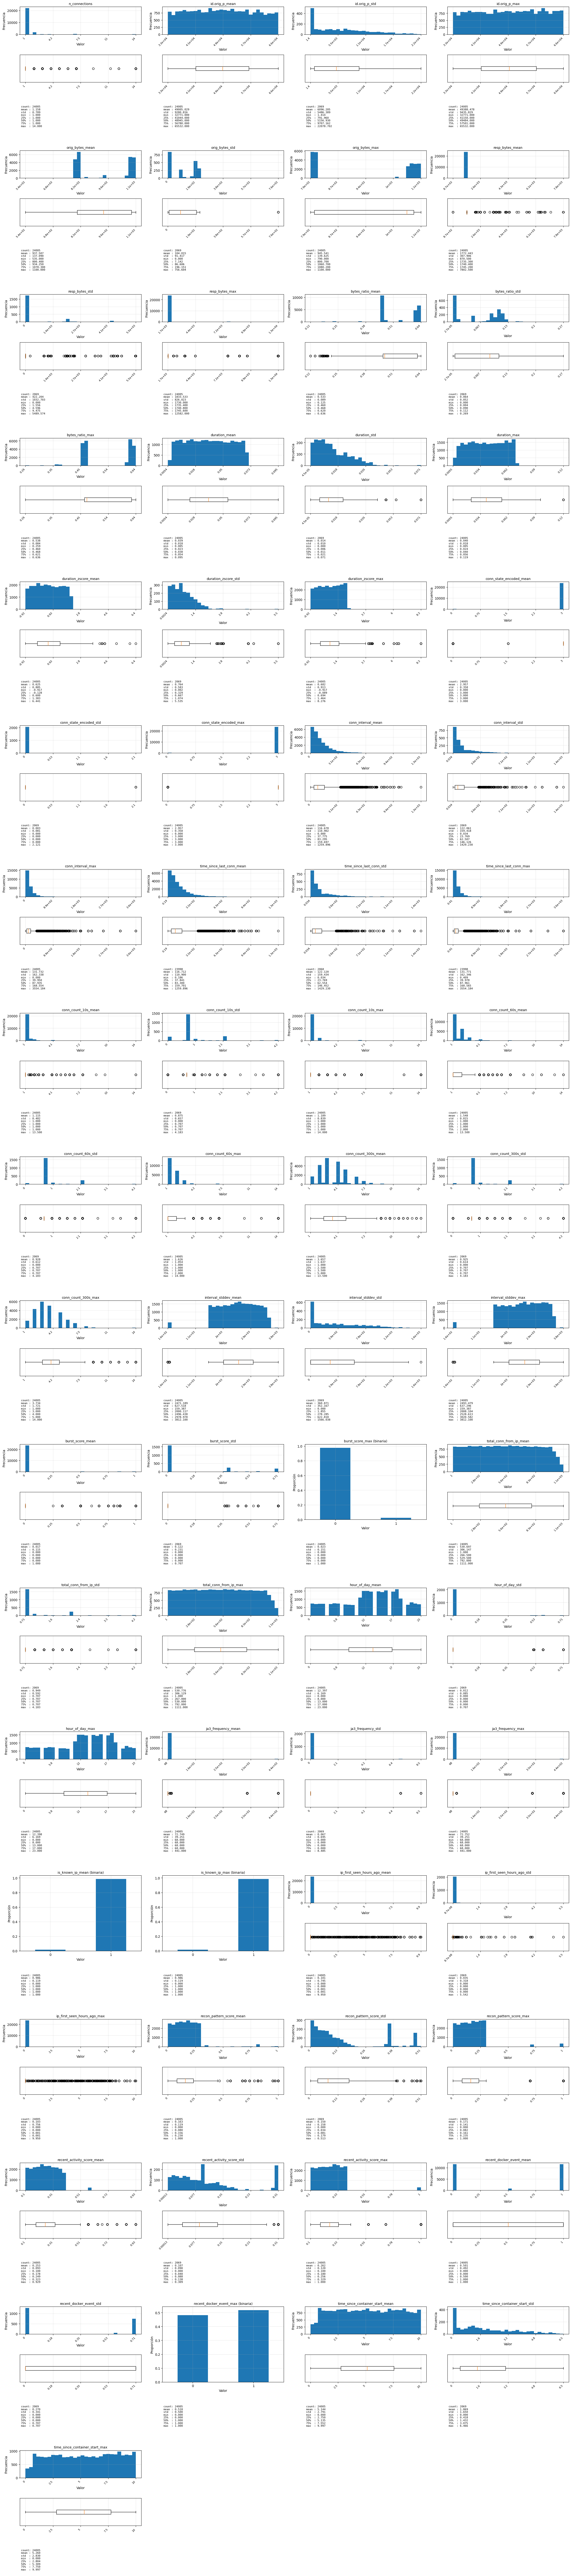

In [ ]:
import math

cols = df_eda.select_dtypes(include='number').columns
n_cols = 4

is_all_same_list = []

plot_idx = 0

n_rows = math.ceil(len(cols) / n_cols)

fig = plt.figure(figsize=(n_cols * 6, n_rows * 6))
gs = fig.add_gridspec(n_rows * 3, n_cols)

for col in cols:
    data = df_eda[col].dropna()
    desc = data.describe()
    vtype = variable_type(data)
    is_all_same_flag = is_all_same(data)

    if is_all_same_flag:
        is_all_same_list.append(col)
        continue

    row = (plot_idx // n_cols) * 3
    col_pos = plot_idx % n_cols


    if vtype == "continuous":
        ax1 = fig.add_subplot(gs[row, col_pos])
        ax1.hist(data, bins=30)
        ax1.set_title(col, fontsize=10)
        ax1.set_xlabel("Valor")
        ax1.set_ylabel("Frecuencia")

        xtick_values = np.linspace(desc['min'], desc['max'], num=5)
        ax1.set_xticks(xtick_values)
        ax1.set_xticklabels([f"{x:.2g}" for x in xtick_values], rotation=45, ha='right')
        ax1.tick_params(axis='x', labelsize=8)
        ax1.grid(alpha=0.3)

        ax2 = fig.add_subplot(gs[row + 1, col_pos])
        ax2.boxplot(data, vert=False)
        ax2.set_yticks([])
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(xtick_values)
        ax2.set_xticklabels([f"{x:.2g}" for x in xtick_values], rotation=45, ha='right')
        ax2.tick_params(axis='x', labelsize=8)
        ax2.grid(alpha=0.3)

    elif vtype == "binary":
        counts = data.value_counts(normalize=True).sort_index()

        ax1 = fig.add_subplot(gs[row:row + 2, col_pos])
        counts.plot(kind="bar", ax=ax1)
        ax1.set_title(f"{col} (binaria)", fontsize=10)
        ax1.set_ylabel("Proporción")
        ax1.set_xlabel("Valor")
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(["0", "1"], rotation=0)
        ax1.grid(alpha=0.3)

    ax3 = fig.add_subplot(gs[row + 2, col_pos])
    ax3.axis("off")

    ax3.text(
        0.01, 0.5,
        f"count: {int(desc['count'])}\n"
        f"mean : {desc['mean']:.3f}\n"
        f"std  : {desc['std']:.3f}\n"
        f"min  : {desc['min']:.3f}\n"
        f"25%  : {desc['25%']:.3f}\n"
        f"50%  : {desc['50%']:.3f}\n"
        f"75%  : {desc['75%']:.3f}\n"
        f"max  : {desc['max']:.3f}",
        fontsize=8,
        family="monospace",
        va="center"
    )

    plot_idx += 1

plt.tight_layout()
plt.show()

La representación gráfica de las variables permite una interpretación mucho más clara del comportamiento del dataset que la obtenida mediante estadísticas agregadas. La combinación de histogramas, boxplots y gráficos específicos según el tipo de variable facilita la identificación de patrones, dispersiones y valores atípicos que no resultan evidentes en un análisis puramente tabular.

En términos generales, se observa que un conjunto reducido de variables, como id.orig_p_mean, id.orig_p_max, interval_stddev_mean, interval_stddev_max, total_conn_from_ip_mean, total_conn_from_ip_max, time_since_container_start_mean y time_since_container_start_max, presentan distribuciones relativamente uniformes y bien repartidas a lo largo de su rango de valores. Estas variables no muestran concentraciones extremas ni picos dominantes, aunque en algunos casos aparecen valores atípicos puntuales que podrían corresponder a comportamientos excepcionales del sistema.

La mayoría de las variables analizadas presentan algún grado de presencia de outliers, lo cual es esperable en un entorno de tráfico de red y comportamiento temporal agregado. Estos valores extremos resultan especialmente relevantes en el contexto de detección de anomalías, ya que pueden reflejar desviaciones significativas respecto al comportamiento normal.

Por otro lado, las variables binarias muestran, en general, una tendencia clara hacia uno de sus valores, indicando una distribución desbalanceada. Una excepción destacable es recent_docker_event_max, que presenta una distribución más equilibrada entre ambos estados. Un análisis posterior de las distribuciones permitirá evaluar si estas variables presentan asimetrías (skewness) relevantes y determinar su impacto en el modelo de clustering.

In [43]:
print(is_all_same_list)

['id.resp_p_mean', 'id.resp_p_std', 'id.resp_p_max', 'ja3_is_known_mean', 'ja3_is_known_std', 'ja3_is_known_max', 'ja3_behavior_score_mean', 'ja3_behavior_score_std', 'ja3_behavior_score_max', 'unique_ja3_from_ip_mean', 'unique_ja3_from_ip_std', 'unique_ja3_from_ip_max', 'is_known_ip_std', 'id.resp_h_nunique', 'ja3_nunique']


Durante el análisis exploratorio se identificaron varias columnas cuyos valores son constantes en todas las observaciones. Este tipo de variables no aporta información discriminativa ni contribuye a la separación entre comportamientos normales y anómalos, por lo que se eliminan del dataset con el objetivo de reducir la dimensionalidad y evitar ruido innecesario en el modelo.

In [44]:
df_clean = df_eda.drop(columns=['id.resp_p_mean', 'id.resp_p_std', 'id.resp_p_max', 'ja3_is_known_mean', 'ja3_is_known_std', 'ja3_is_known_max', 'ja3_behavior_score_mean', 'ja3_behavior_score_std', 'ja3_behavior_score_max', 'unique_ja3_from_ip_mean', 'unique_ja3_from_ip_std', 'unique_ja3_from_ip_max', 'is_known_ip_std', 'id.resp_h_nunique', 'ja3_nunique'])
df_clean.head()

,n_connections,id.orig_p_mean,id.orig_p_std,id.orig_p_max,orig_bytes_mean,orig_bytes_std,orig_bytes_max,resp_bytes_mean,resp_bytes_std,resp_bytes_max,bytes_ratio_mean,bytes_ratio_std,bytes_ratio_max,duration_mean,duration_std,duration_max,duration_zscore_mean,duration_zscore_std,duration_zscore_max,conn_state_encoded_mean,conn_state_encoded_std,conn_state_encoded_max,conn_interval_mean,conn_interval_std,conn_interval_max,time_since_last_conn_mean,time_since_last_conn_std,time_since_last_conn_max,conn_count_10s_mean,conn_count_10s_std,conn_count_10s_max,conn_count_60s_mean,conn_count_60s_std,conn_count_60s_max,conn_count_300s_mean,conn_count_300s_std,conn_count_300s_max,interval_stddev_mean,interval_stddev_std,interval_stddev_max,burst_score_mean,burst_score_std,burst_score_max,total_conn_from_ip_mean,total_conn_from_ip_std,total_conn_from_ip_max,hour_of_day_mean,hour_of_day_std,hour_of_day_max,ja3_frequency_mean,ja3_frequency_std,ja3_frequency_max,is_known_ip_mean,is_known_ip_max,ip_first_seen_hours_ago_mean,ip_first_seen_hours_ago_std,ip_first_seen_hours_ago_max,recon_pattern_score_mean,recon_pattern_score_std,recon_pattern_score_max,recent_activity_score_mean,recent_activity_score_std,recent_activity_score_max,recent_docker_event_mean,recent_docker_event_std,recent_docker_event_max,time_since_container_start_mean,time_since_container_start_std,time_since_container_start_max
0,7,47966.000000,14.651507,47994,839.285714,86.765420,1034.0,3414.000000,2070.480943,7605.0,0.230968,0.092975,0.364213,0.011819,0.007306,0.023863,-0.112138,0.572702,0.831992,0.0,0.0,0,0.291857,0.213721,0.533362,0.340500,0.186913,0.533362,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.857143,0.377964,1.0,4.0,2.160247,7,11.0,0.0,11,441.0,0.0,441,0.0,0,0.000298,0.000224,0.000567,0.842857,0.304725,1.0,0.571429,0.308607,1.000000,0.0,0.0,0,0.0,0.0,0.0
1,2,53218.000000,11.313708,53226,800.000000,2.828427,802.0,5499.500000,4575.687981,8735.0,0.172354,0.124819,0.260614,0.009043,0.003304,0.011380,-0.329696,0.259022,-0.146540,0.0,0.0,0,346.411312,489.438990,692.496940,346.411312,489.438990,692.496940,1.5,0.707107,2,1.5,0.707107,2,1.5,0.707107,2,159.386835,0.0,159.386835,0.500000,0.707107,1.0,8.5,0.707107,9,11.0,0.0,11,441.0,0.0,441,0.0,0,0.133722,0.000064,0.133767,0.350000,0.494975,0.7,0.214286,0.101015,0.285714,0.0,0.0,0,0.0,0.0,0.0
2,7,50166.857143,5235.425848,53248,837.142857,85.407706,1029.0,6332.285714,4362.650942,12578.0,0.179339,0.128890,0.363091,0.010744,0.005597,0.021910,-0.196362,0.438734,0.678898,0.0,0.0,0,99.219643,261.610753,692.496940,99.219643,261.610753,692.496940,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.857143,0.377964,1.0,11.0,2.160247,14,11.0,0.0,11,441.0,0.0,441,0.0,0,0.133974,0.000224,0.134244,0.814286,0.376070,1.0,0.571429,0.308607,1.000000,0.0,0.0,0,0.0,0.0,0.0
3,7,50166.857143,5235.425848,53248,837.142857,85.407706,1029.0,6332.285714,4362.650942,12578.0,0.179339,0.128890,0.363091,0.010744,0.005597,0.021910,-0.196362,0.438734,0.678898,0.0,0.0,0,99.219643,261.610753,692.496940,99.219643,261.610753,692.496940,4.0,2.160247,7,4.0,2.160247,7,4.0,2.160247,7,159.386835,0.0,159.386835,0.857143,0.377964,1.0,11.0,2.160247,14,11.0,0.0,11,441.0,0.0,441,0.0,0,0.133974,0.000224,0.134244,0.814286,0.376070,1.0,0.571429,0.308607,1.000000,0.0,0.0,0,0.0,0.0,0.0
4,5,48946.400000,5881.994798,53248,852.000000,99.869915,1029.0,6665.400000,4778.010287,12578.0,0.182133,0.144879,0.363091,0.011425,0.006499,0.021910,-0.143028,0.509424,0.678898,0.0,0.0,0,0.342975,0.207732,0.528486,0.342975,0.207732,0.528486,5.0,1.581139,7,5.0,1.581139,7,5.0,1.581139,7,159.386835,0.0,159.386835,1.000000,0.000000,1.0,12.0,1.581139,14,11.0,0.0,11,441.0,0.0,441,0.0,0,0.134075,0.000173,0.134244,1.000000,0.000000,1.0,0.714286,0.225877,1.000000,0.0,0.0,0,0.0,0.0,0.0


## Correlación entre atributos

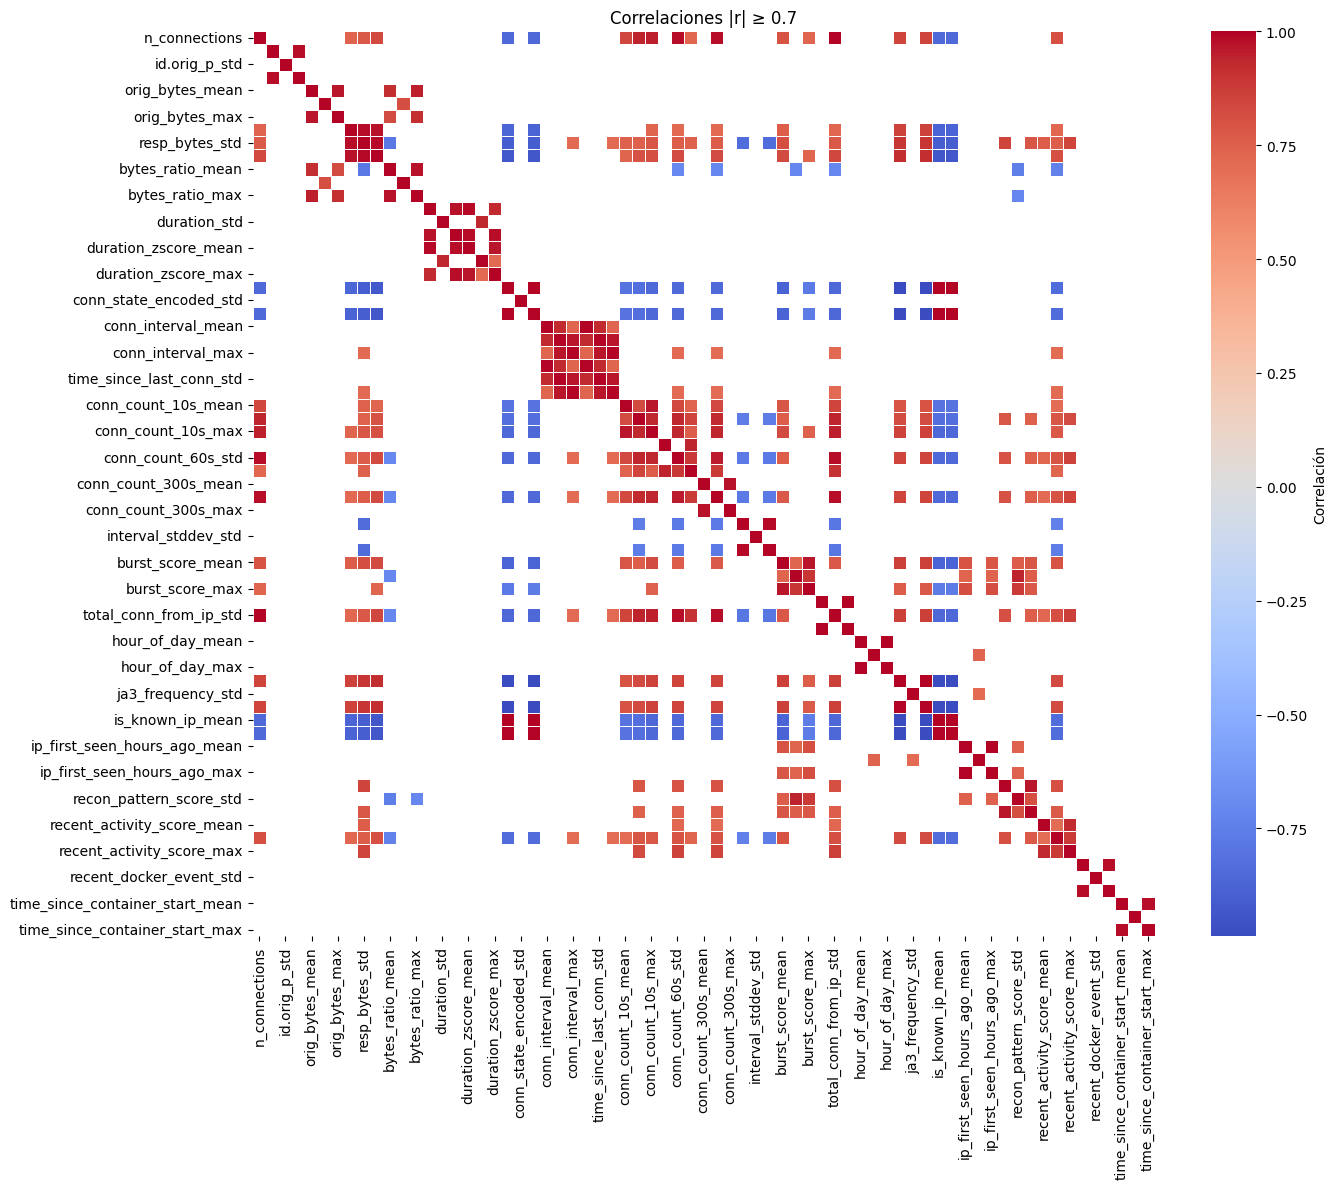

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_clean.corr()

# Umbral de correlación
threshold = 0.7

mask = np.abs(corr) < threshold

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={"label": "Correlación"}
)

plt.title(f"Correlaciones |r| ≥ {threshold}")
plt.tight_layout()
plt.show()

### Importancia de la Correlación en el Dataset
El análisis de correlación es fundamental en este proyecto de detección de anomalías por varias razones críticas:
Reducción de dimensionalidad: Las correlaciones extremadamente altas (≥0.95) indican que múltiples variables están capturando esencialmente la misma información. En modelos de machine learning, especialmente en algoritmos basados en distancias como Isolation Forest, mantener variables redundantes puede distorsionar el espacio de características y reducir la capacidad del modelo para detectar patrones anómalos sutiles.
Eficiencia computacional: Cada variable adicional incrementa la complejidad computacional del modelo. Eliminar redundancias permite entrenamientos más rápidos y predicciones en tiempo real más eficientes, algo crítico en sistemas de detección de intrusiones donde la latencia es un factor determinante.
Interpretabilidad: Un modelo con menos variables correlacionadas es más fácil de interpretar y explicar. Cuando se detecta una anomalía, es esencial poder identificar qué características específicas contribuyeron a esa decisión para facilitar la respuesta del equipo de seguridad.
Conclusiones del Análisis
1. Grupos de Características Altamente Correlacionadas
Estado de conexión e IPs conocidas (correlación perfecta 1.000): Las variables conn_state_encoded_max, is_known_ip_mean e is_known_ip_max están completamente correlacionadas, sugiriendo que el estado de la conexión está determinado principalmente por si la IP es conocida o no. Esto podría indicar que las conexiones legítimas a Consul provienen consistentemente de IPs conocidas.
Métricas temporales (correlación perfecta 1.000): conn_interval_max y time_since_last_conn_max capturan la misma información temporal, al igual que sus variantes con std y mean. Esto es lógico ya que ambas miden intervalos temporales desde perspectivas similares.
Agregaciones estadísticas: Las correlaciones perfectas entre mean y max en variables como total_conn_from_ip, hour_of_day y ja3_frequency sugieren que hay poca variabilidad en las ventanas temporales analizadas, o que los valores extremos dominan las métricas agregadas.
2. Relaciones Negativas Importantes
La correlación negativa fuerte (-0.987) entre conn_state_encoded y ja3_frequency revela un patrón de seguridad importante: las conexiones con estados "anormales" tienden a tener huellas digitales TLS (JA3) inusuales. Esto podría ser un indicador clave de ataques de Consul Poisoning, donde los atacantes utilizan herramientas automatizadas con configuraciones TLS distintas a las de clientes legítimos.
3. Patrones de Tráfico y Actividad Sospechosa
Las correlaciones altas entre burst_score, recon_pattern_score y métricas de conexión (conn_count_*) indican que los patrones de reconocimiento suelen manifestarse como ráfagas de conexiones. Este es un comportamiento típico de herramientas de escaneo y exploración de vulnerabilidades.

### Variables Redundantes Recomendadas para Eliminación
- is_known_ip_mean - Redundante con is_known_ip_max (1.000)
- conn_state_encoded_mean - Redundante con conn_state_encoded_max (0.999)
- time_since_last_conn_max - Redundante con conn_interval_max (1.000)
- time_since_last_conn_std - Redundante con conn_interval_std (1.000)
- time_since_last_conn_mean - Redundante con conn_interval_mean (1.000)
- total_conn_from_ip_mean - Redundante con total_conn_from_ip_max (1.000)
- hour_of_day_mean - Redundante con hour_of_day_max (1.000)
- ja3_frequency_mean - Redundante con ja3_frequency_max (1.000)
- ip_first_seen_hours_ago_mean - Redundante con ip_first_seen_hours_ago_max (0.997)
- resp_bytes_std - Alta correlación con resp_bytes_max (0.988)

- interval_stddev_mean - Redundante con interval_stddev_max (0.987)
- id.orig_p_mean - Redundante con id.orig_p_max (0.983)
- time_since_container_start_mean - Redundante con time_since_container_start_max (0.983)
- recent_docker_event_mean - Redundante con recent_docker_event_max (0.984)
- conn_count_300s_mean - Redundante con conn_count_300s_max (0.974)
- bytes_ratio_mean - Redundante con bytes_ratio_max (0.970)
- conn_count_10s_mean - Redundante con conn_count_10s_max (0.967)
- burst_score_mean - Redundante con burst_score_max (0.964)
- recon_pattern_score_mean - Redundante con recon_pattern_score_max (0.964)
- duration_zscore_mean - Redundante con duration_zscore_max (0.963)

In [60]:
df_clean_after_delete = df_clean.drop(columns=['is_known_ip_mean', 'conn_state_encoded_mean', 'time_since_last_conn_max', 'time_since_last_conn_std', 'time_since_last_conn_mean',
                                  'total_conn_from_ip_mean', 'hour_of_day_mean', 'ja3_frequency_mean', 'ip_first_seen_hours_ago_mean', 'resp_bytes_std', 'interval_stddev_mean',
                                  'id.orig_p_mean', 'time_since_container_start_mean', 'recent_docker_event_mean', 'conn_count_300s_mean', 'bytes_ratio_mean', 'conn_count_10s_mean',
                                  'burst_score_mean', 'recon_pattern_score_mean', 'duration_zscore_mean'])
df_clean_after_delete.head()

,n_connections,id.orig_p_std,id.orig_p_max,orig_bytes_mean,orig_bytes_std,orig_bytes_max,resp_bytes_mean,resp_bytes_max,bytes_ratio_std,bytes_ratio_max,duration_mean,duration_std,duration_max,duration_zscore_std,duration_zscore_max,conn_state_encoded_std,conn_state_encoded_max,conn_interval_mean,conn_interval_std,conn_interval_max,conn_count_10s_std,conn_count_10s_max,conn_count_60s_mean,conn_count_60s_std,conn_count_60s_max,conn_count_300s_std,conn_count_300s_max,interval_stddev_std,interval_stddev_max,burst_score_std,burst_score_max,total_conn_from_ip_std,total_conn_from_ip_max,hour_of_day_std,hour_of_day_max,ja3_frequency_std,ja3_frequency_max,is_known_ip_max,ip_first_seen_hours_ago_std,ip_first_seen_hours_ago_max,recon_pattern_score_std,recon_pattern_score_max,recent_activity_score_mean,recent_activity_score_std,recent_activity_score_max,recent_docker_event_std,recent_docker_event_max,time_since_container_start_std,time_since_container_start_max
0,7,14.651507,47994,839.285714,86.765420,1034.0,3414.000000,7605.0,0.092975,0.364213,0.011819,0.007306,0.023863,0.572702,0.831992,0.0,0,0.291857,0.213721,0.533362,2.160247,7,4.0,2.160247,7,2.160247,7,0.0,159.386835,0.377964,1.0,2.160247,7,0.0,11,0.0,441,0,0.000224,0.000567,0.304725,1.0,0.571429,0.308607,1.000000,0.0,0,0.0,0.0
1,2,11.313708,53226,800.000000,2.828427,802.0,5499.500000,8735.0,0.124819,0.260614,0.009043,0.003304,0.011380,0.259022,-0.146540,0.0,0,346.411312,489.438990,692.496940,0.707107,2,1.5,0.707107,2,0.707107,2,0.0,159.386835,0.707107,1.0,0.707107,9,0.0,11,0.0,441,0,0.000064,0.133767,0.494975,0.7,0.214286,0.101015,0.285714,0.0,0,0.0,0.0
2,7,5235.425848,53248,837.142857,85.407706,1029.0,6332.285714,12578.0,0.128890,0.363091,0.010744,0.005597,0.021910,0.438734,0.678898,0.0,0,99.219643,261.610753,692.496940,2.160247,7,4.0,2.160247,7,2.160247,7,0.0,159.386835,0.377964,1.0,2.160247,14,0.0,11,0.0,441,0,0.000224,0.134244,0.376070,1.0,0.571429,0.308607,1.000000,0.0,0,0.0,0.0
3,7,5235.425848,53248,837.142857,85.407706,1029.0,6332.285714,12578.0,0.128890,0.363091,0.010744,0.005597,0.021910,0.438734,0.678898,0.0,0,99.219643,261.610753,692.496940,2.160247,7,4.0,2.160247,7,2.160247,7,0.0,159.386835,0.377964,1.0,2.160247,14,0.0,11,0.0,441,0,0.000224,0.134244,0.376070,1.0,0.571429,0.308607,1.000000,0.0,0,0.0,0.0
4,5,5881.994798,53248,852.000000,99.869915,1029.0,6665.400000,12578.0,0.144879,0.363091,0.011425,0.006499,0.021910,0.509424,0.678898,0.0,0,0.342975,0.207732,0.528486,1.581139,7,5.0,1.581139,7,1.581139,7,0.0,159.386835,0.000000,1.0,1.581139,14,0.0,11,0.0,441,0,0.000173,0.134244,0.000000,1.0,0.714286,0.225877,1.000000,0.0,0,0.0,0.0


## Gráficas de densidad

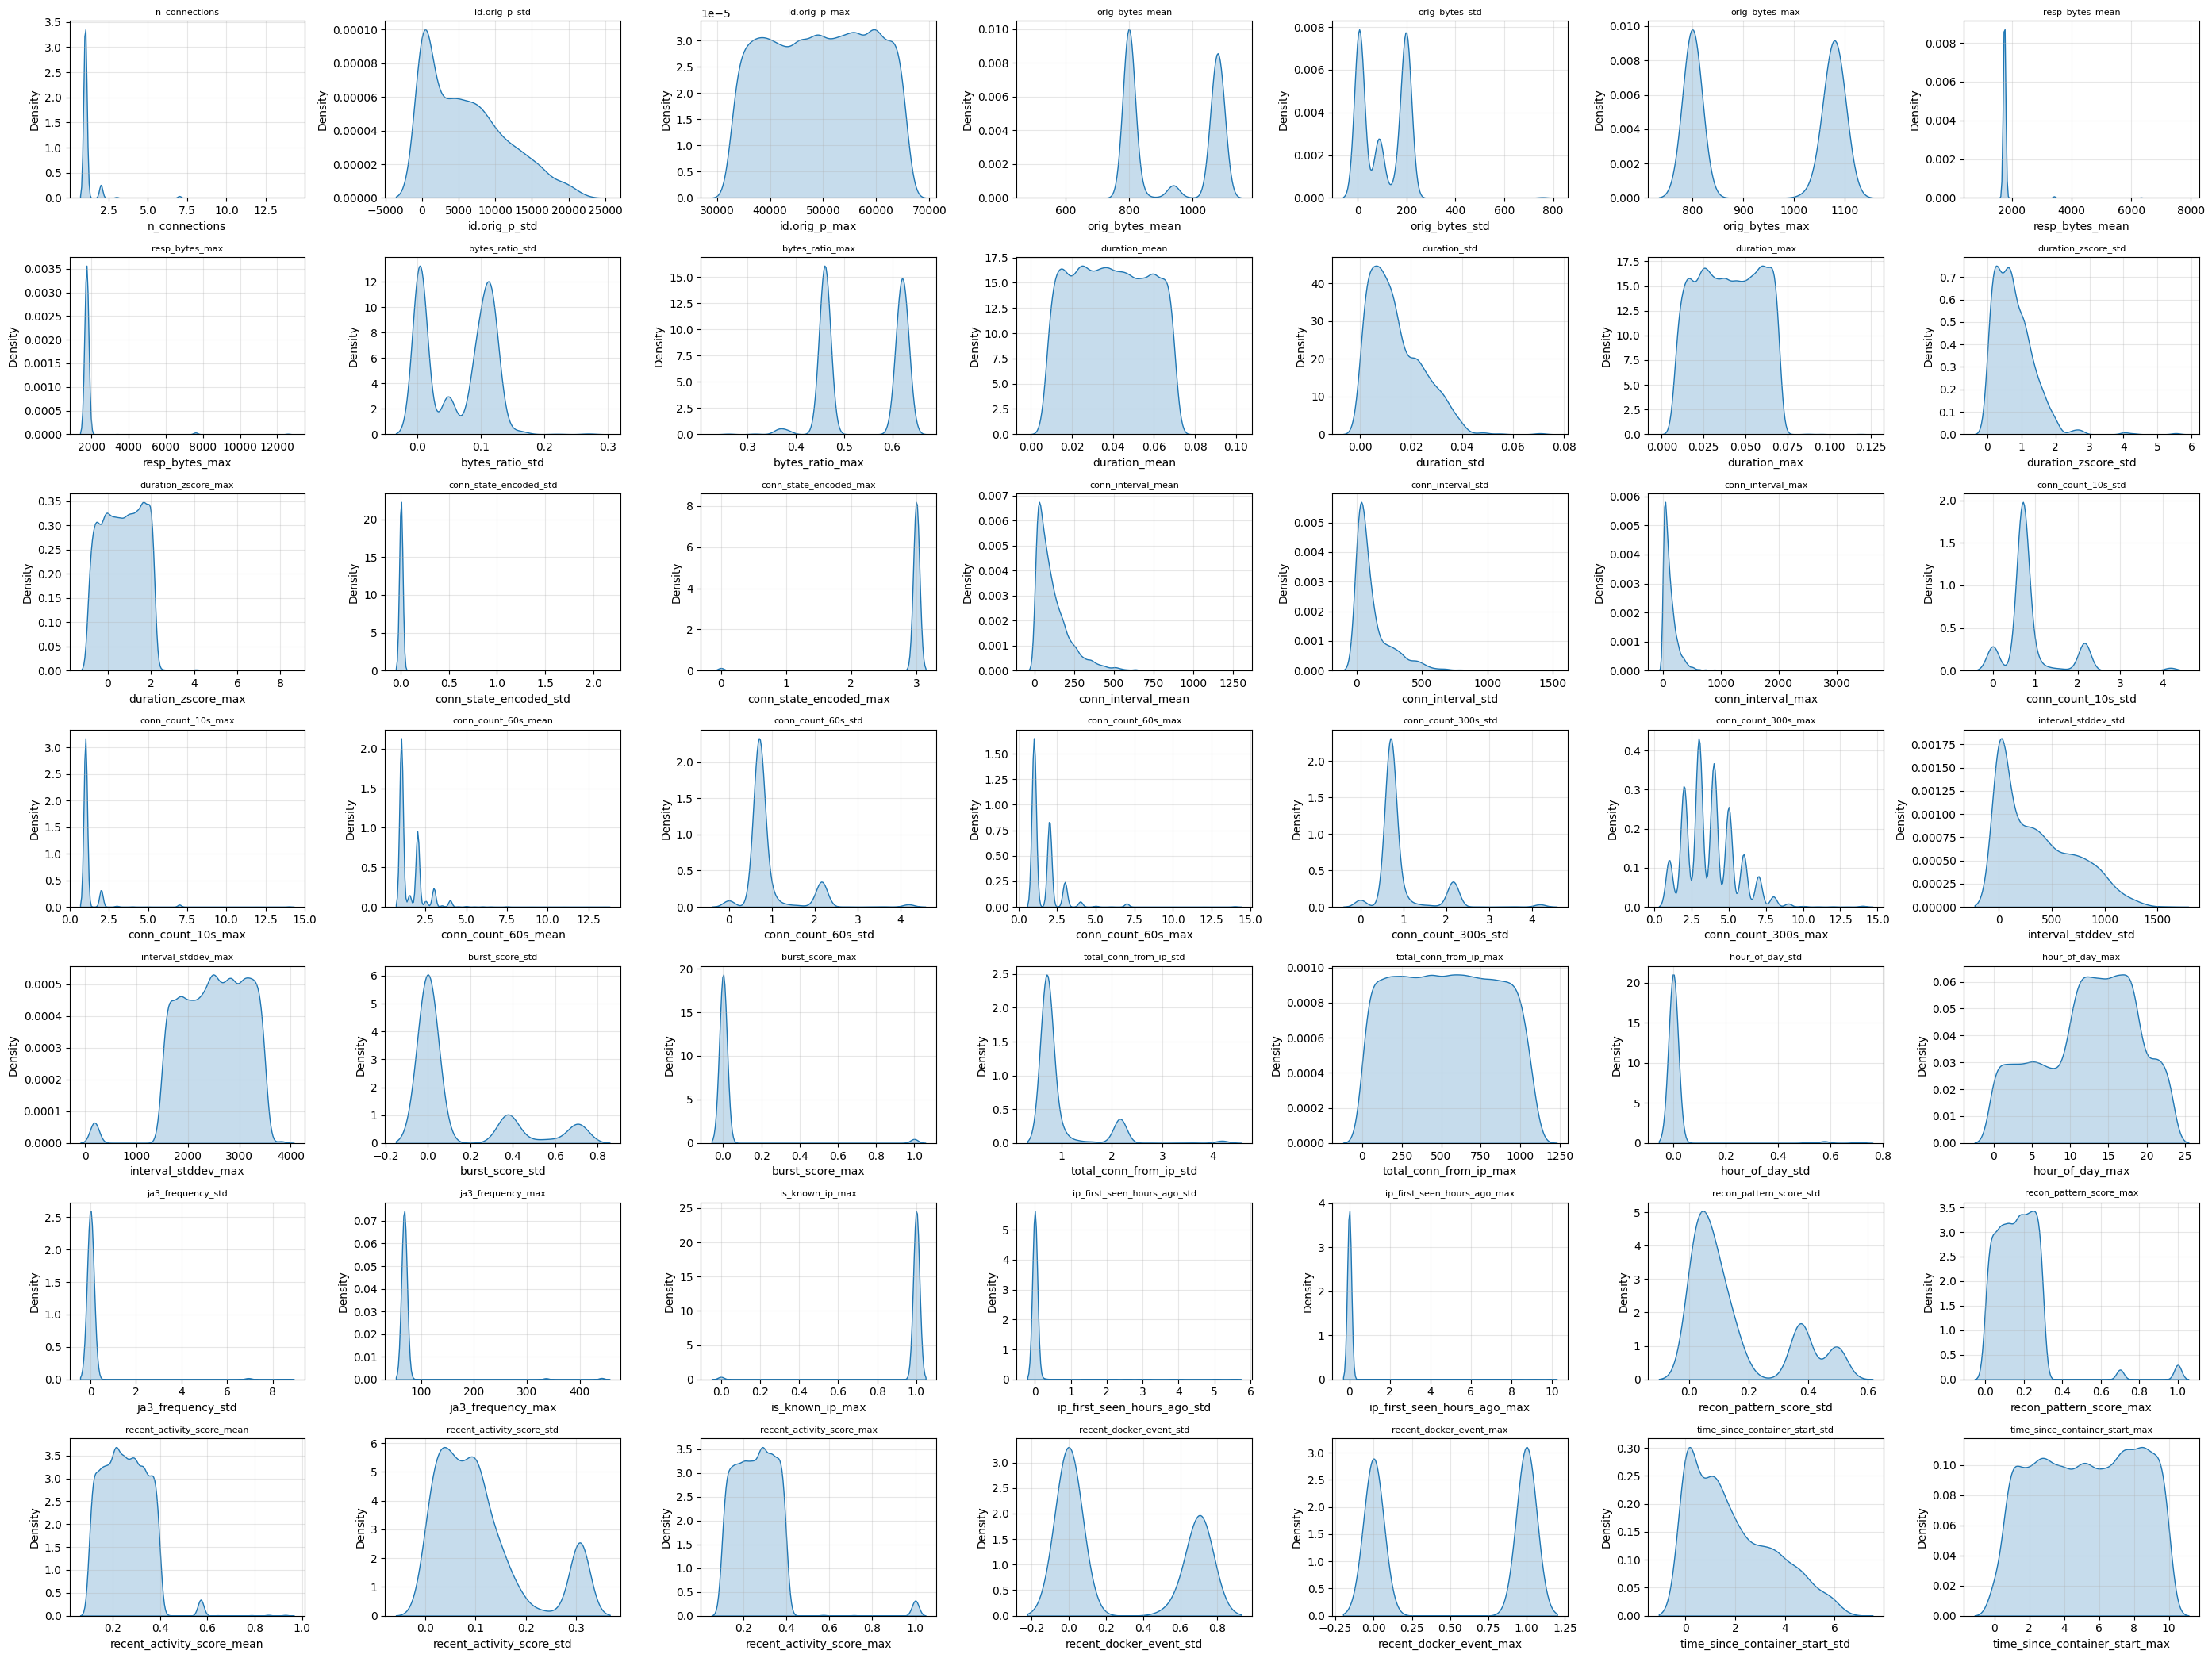

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Seleccionamos solo columnas numéricas
num_cols = df_clean_after_delete.select_dtypes(include='number').columns

# Layout 7x7
n_cols = 7
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()  # para iterar fácilmente

for i, col in enumerate(num_cols):
    data = df_clean_after_delete[col].dropna()
    sns.kdeplot(data, ax=axes[i], fill=True)
    axes[i].set_title(col, fontsize=8)
    axes[i].grid(alpha=0.3)

# Eliminamos ejes sobrantes si hay menos de n_rows*n_cols columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [66]:
# Análisis cuantitativo de las distribuciones de densidad
from scipy import stats

print("=== ANÁLISIS DE FORMAS DE DISTRIBUCIÓN ===\n")

distribution_analysis = []
for col in df_clean_after_delete.select_dtypes(include='number').columns:
    data = df_clean_after_delete[col].dropna()
    if len(data) > 0 and data.std() > 0:
        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)
        zero_pct = (data == 0).sum() / len(data) * 100
        mode_approx = data.mode().iloc[0] if len(data.mode()) > 0 else np.nan
        
        distribution_analysis.append({
            'variable': col,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'zero_pct': zero_pct,
            'mean': data.mean(),
            'median': data.median(),
            'std': data.std()
        })

dist_df = pd.DataFrame(distribution_analysis)

# Clasificación de distribuciones
print("📊 DISTRIBUCIONES CON ALTA ASIMETRÍA POSITIVA (cola derecha):")
high_right_skew = dist_df[dist_df['skewness'] > 2].sort_values('skewness', ascending=False)
print(high_right_skew[['variable', 'skewness', 'kurtosis', 'zero_pct']].head(15))

print("\n📊 DISTRIBUCIONES CON CURTOSIS ALTA (colas pesadas/picos):")
high_kurtosis = dist_df[dist_df['kurtosis'] > 10].sort_values('kurtosis', ascending=False)
print(high_kurtosis[['variable', 'skewness', 'kurtosis']].head(10))

print("\n📊 DISTRIBUCIONES APROXIMADAMENTE SIMÉTRICAS (|skewness| < 0.5):")
symmetric = dist_df[abs(dist_df['skewness']) < 0.5]
print(symmetric[['variable', 'skewness', 'kurtosis']].head(10))

print("\n📊 VARIABLES CON ALTA CONCENTRACIÓN EN CERO:")
zero_heavy = dist_df[dist_df['zero_pct'] > 50].sort_values('zero_pct', ascending=False)
print(zero_heavy[['variable', 'zero_pct', 'mean', 'median']])

=== ANÁLISIS DE FORMAS DE DISTRIBUCIÓN ===

📊 DISTRIBUCIONES CON ALTA ASIMETRÍA POSITIVA (cola derecha):
                       variable   skewness    kurtosis   zero_pct
15       conn_state_encoded_std  26.204353  684.668119  99.855002
6               resp_bytes_mean  11.761267  157.365298   0.000000
38  ip_first_seen_hours_ago_std  11.524039  146.576116   0.000000
35            ja3_frequency_std  10.420763  107.626592  99.081682
7                resp_bytes_max   9.729801  101.811828   0.000000
0                 n_connections   8.801070   99.420035   0.000000
36            ja3_frequency_max   8.451744   70.998793   0.000000
39  ip_first_seen_hours_ago_max   8.235158   71.683803   0.008332
21           conn_count_10s_max   8.209803   87.492873   0.000000
33              hour_of_day_std   6.949822   47.039070  97.970034
30              burst_score_max   6.315850   37.889957  97.667153
19            conn_interval_max   5.601316   63.821347   0.029161
24           conn_count_60s_max   4.0

### Análisis de las gráficas de densidad (KDE)

Las gráficas de densidad kernel (KDE) permiten visualizar la forma subyacente de las distribuciones de cada variable, complementando la información proporcionada por los histogramas y boxplots anteriores. A continuación se describen los principales patrones observados:

#### 1. Distribuciones con pico pronunciado cerca de cero (Spike-at-zero)

Un patrón muy frecuente en el dataset es la presencia de distribuciones con un pico extremadamente alto en valores cercanos a cero, seguido de una cola larga hacia la derecha. Este comportamiento es característico de:

- **`conn_state_encoded_std`** (99.9% ceros): La desviación estándar del estado de conexión es casi siempre cero, indicando que dentro de cada ventana temporal las conexiones mantienen un estado consistente.
- **`ja3_frequency_std`** (99.1% ceros): La variabilidad en la frecuencia de firmas JA3 dentro de una ventana es prácticamente nula en condiciones normales.
- **`burst_score_max`** (97.7% ceros) y **`burst_score_std`** (76.1% ceros): El comportamiento de ráfaga es raro, apareciendo solo en el 2.3% de las ventanas.
- **`hour_of_day_std`** (98% ceros): Las conexiones dentro de una misma ventana ocurren prácticamente en el mismo momento.

Estas variables presentan **curtosis extremadamente alta** (>100 en varios casos), lo que indica distribuciones leptocúrticas con colas muy pesadas. Los valores no nulos en estas variables podrían ser indicadores importantes de comportamiento anómalo.

#### 2. Distribuciones simétricas o cuasi-normales

Un subconjunto de variables muestra distribuciones relativamente simétricas (|skewness| < 0.5), lo que sugiere un comportamiento más "estable" y predecible:

- **`id.orig_p_max`**: Los puertos de origen presentan una distribución uniforme, sin sesgo hacia valores específicos.
- **`orig_bytes_mean/max`**: Los bytes de origen se distribuyen de forma simétrica alrededor de su media.
- **`bytes_ratio_std/max`**: La ratio entre bytes enviados y recibidos muestra simetría.
- **`duration_mean/max`**: La duración de las conexiones sigue una distribución equilibrada.
- **`total_conn_from_ip_max`**: El total de conexiones desde una IP se distribuye uniformemente.
- **`hour_of_day_max`**: La hora del día presenta una distribución ligeramente sesgada a la izquierda, reflejando posiblemente patrones de actividad diurna.

Estas variables tienen **curtosis negativa** (distribución platicúrtica), indicando colas más ligeras que una distribución normal y ausencia de valores extremos.

#### 3. Distribuciones con cola derecha pronunciada

Las siguientes variables muestran un sesgo positivo significativo (skewness > 2), con la masa de probabilidad concentrada en valores bajos:

- **`n_connections`** (skewness: 8.8): La mayoría de ventanas contienen 1-2 conexiones, pero existen casos con hasta 14.
- **`resp_bytes_mean/max`** (skewness: ~10-12): El volumen de respuesta es típicamente bajo (~1700 bytes), con outliers que alcanzan ~12KB.
- **`conn_interval_max`**: Los intervalos máximos entre conexiones varían enormemente.
- **`conn_count_10s_max`** y **`conn_count_60s_max`**: El conteo de conexiones en ventanas cortas muestra alta variabilidad.
- **`ip_first_seen_hours_ago_std/max`** (skewness: ~8-11): El tiempo desde que se vio una IP por primera vez presenta valores extremos.

#### 4. Variable con asimetría negativa

**`is_known_ip_max`** presenta un comportamiento inverso (skewness: -8.15), con la mayoría de valores concentrados en 1 (IP conocida) y una pequeña fracción en 0. Esto confirma que el tráfico proviene predominantemente de fuentes identificadas.

#### 5. Implicaciones para el modelado

El análisis de densidad revela que:

1. **Transformaciones necesarias**: Las variables con alta asimetría positiva requerirán transformaciones logarítmicas o Box-Cox para aproximarlas a distribuciones normales antes de aplicar ciertos algoritmos.

2. **Variables discriminativas**: Las distribuciones con "spike-at-zero" son especialmente interesantes para detección de anomalías, ya que cualquier valor no nulo ya representa una desviación del comportamiento típico.

3. **Robustez del modelo**: La presencia de distribuciones multimodales y con colas pesadas sugiere que algoritmos como Isolation Forest o HDBSCAN, que no asumen normalidad, serán más adecuados que métodos basados en distancias euclidianas.

4. **Escalado**: Dado el amplio rango de escalas entre variables (desde 0-1 en ratios hasta miles en bytes), será imprescindible aplicar normalización robusta (como RobustScaler) que sea menos sensible a outliers.